# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [1]:
# ploting
%matplotlib inline
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

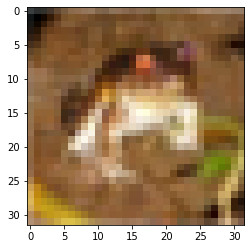

In [2]:
# data loading
cifar_sample = np.load('./resources/cifar_sample.npy')
# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1,2,0)) 

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = \text{???} $  

$ \hspace{140px} H_o = \text{???} $  

$ \hspace{140px} W_o = \text{???} $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   


### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="./resources/cnn.gif"></img>

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli). 

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [45]:
from torch.nn.functional import pad as pad
import torchvision.transforms.functional as TF
import traceback
import sys

def convolution(image: torch.tensor, 
                filters: torch.tensor, 
                bias: torch.tensor, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    # torch.Size([3, 32, 32])
    img_channels, img_height, img_width = image.shape 
    # torch.Size([2, 3, 3, 3])
    n_filters, filter_channels, filter_size, filter_size = filters.shape 
    # calculate the dimensions of the output image 30x30
    out_height = int(((img_height - filter_size + 2 * padding) / stride) + 1)
    out_width = int(((img_width - filter_size + 2 * padding) / stride) + 1)
    image_orig = image
    # torch.Size([3, 34, 34])
    image_padded = pad(image_orig, (0, 0, 2, 1))
    img_channels2, img_height2, img_width2 = image_padded.shape 
    
    # Iterate through image
    output = torch.zeros((n_filters,out_height,out_width))
    for i in range(n_filters):
        for c in range(img_channels):
            for j in range(0, img_height - filter_size + 1, stride):
                for x in range(0, img_width - filter_size + 1, stride):
                    img_crop = image_padded[:, j:j+filter_size, x:x+filter_size]
                    filter_tab = filters[i,:,:,:] 
                    output[:, j // stride, x // stride] = torch.multiply(filter_tab,img_crop).sum() + bias[i]
    return output

In [46]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [(torch.randn((2,3,3,3)), torch.randn((2))),
           (torch.randn((2,3,5,5)), torch.randn((2))),
           (torch.randn((5,3,1,1)), torch.randn((5)))]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    # PyTorch equivalent
    out_torch = torch.conv2d(input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride)
    # asserts
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    print(out_torch)
    print('-'*82)
    print(out[:10])
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

tensor([[[[-1.3151, -1.7664, -1.9380,  ..., -0.8490, -0.8942, -0.9625],
          [-2.3003, -2.5802, -2.5087,  ..., -1.5726, -1.5703, -1.4782],
          [-2.4601, -2.6254, -2.1577,  ..., -1.6001, -1.8023, -1.7849],
          ...,
          [-1.2501, -1.8537, -1.8248,  ..., -2.1004, -0.1001, -0.4254],
          [-1.2675, -1.8226, -1.9734,  ..., -1.9293, -0.2751, -1.0006],
          [-0.7256, -0.9603, -1.2841,  ..., -1.9715, -0.3777, -0.8762]],

         [[ 0.1349,  0.0311,  0.0707,  ...,  1.0591,  1.0485,  0.9024],
          [ 0.0813, -0.1462,  0.0208,  ...,  0.8627,  0.7392,  0.5217],
          [ 0.0547,  0.1113,  0.0994,  ...,  0.7438,  0.6398,  0.6095],
          ...,
          [ 1.0384,  1.0881,  1.0636,  ...,  1.7800,  1.0275,  0.5600],
          [ 1.2976,  1.3406,  1.3545,  ...,  1.3998,  1.1076,  0.4607],
          [ 0.9797,  1.1844,  1.4420,  ...,  0.9888,  1.4394,  0.7136]]]])
----------------------------------------------------------------------------------
tensor([[[-0.1109,

AssertionError: 

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [99]:
def max_pooling(image: torch.tensor, 
                kernel_size: int, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # calculate the dimensions of the output image
    out_height = int(((img_height - kernel_size + 2 * padding) / stride) + 1) 
    out_width = int(((img_width - kernel_size + 2 * padding) / stride) + 1) 
    out_channels = img_channels 

    if padding > 0:
        padded_height = img_height + 2 * padding
        padded_width = img_width + 2 * padding

        padded_img = torch.zeros((img_channels, padded_height, padded_width))
        padded_img[:, padding:-padding, padding:-padding] = image
    else:
        padded_height = img_height
        padded_width = img_width
        padded_img = image

    out = torch.zeros((out_channels, out_height, out_width))

    for i in range(0, padded_height - kernel_size + 1, stride):

        for j in range(0, padded_width - kernel_size + 1, stride):

            img_crop = padded_img[:, i:i+kernel_size, j:j+kernel_size]
                        
            out[:, i // stride, j // stride] = torch.max(torch.max(img_crop, dim=2)[0], dim=1)[0]

    return out
# image_padded[padding+image_orig.shape[0],padding + image_orig.shape[1]] = image_orig
# i:i + filters[x,:,:,:], j:j + filters[x,:,:,:]
#     print('image')
#     print(image)
#     print('filters')
#     print(filters)
#     print('bias')
#     print(bias)
#     print('padding')
#     print(padding)
#     print('stride')
#     print(stride)

In [100]:
# Max Pooling Test
from itertools import product

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride)
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

In [ ]:
#     f = filters.shape[0]
#     whole_output = []
#     for filtr in range(f):
#         warstwa = []
#         for channel in range(img_channels):
#             layer_out = []
#             felus = filters[filtr][channel]
#             for h in range(0, img_height, stride):
#                 line_out = []
#                 for w in range(0, img_width, stride):
#                     mat = image[channel][h:h+filter_size, w:w+filter_size]
#                     if mat.shape == (filter_size, filter_size):
#                         out = mat * felus
#                         out_sum = float(out.sum())
#                 if line_out:
#                     layer_out.append(line_out)
#             warstwa.append(layer_out)
#         whole_output.append(warstwa)
    
#     sub_wynik = torch.tensor(whole_output)
#     warstwa_filtra, x, y, z = sub_wynik.shape

#     WYNIK = []
#     for warstwa in range(warstwa_filtra):
#         sub_wynik[warstwa]
#         b = bias[warstwa]
#         wynik = torch.zeros([y, z], dtype=torch.float64)
#         for i in range(x):
#             wynik += sub_wynik[warstwa][i]
#             #print(f"wynik: {wynik}")
#         wynik += b
#         WYNIK.append(wynik)
#     result = []
#     for i in WYNIK:
#         p = i.tolist()
#         result.append(p)
#     WYNIK = torch.tensor(result)
    
#     return WYNIK
                    

    

#     for i in range(n_filters):
#         for j in range(img_channels):
#             for x in range(out_width):
#                 if x > img_width2 - filter_size:
#                     break
#                 if x % stride == 0:
#                     for z in range(out_height):
#                         if z > img_height2 - filter_size:
#                             break
#                         try: 
#                             biases = torch.full_like(input = filters[i,:,:,:], fill_value = bias[i].item())
# #                             filter_toadd = filters[i,:,:,:] + biases
#                             gowno = (filters[i,j,:,:] * (image_padded[j,x: x + filter_size, z:z + filter_size])).sum()
# #                             print(filters[i,j,:,:])
# #                             print(image_padded[j,x: x + filter_size, z:z + filter_size])
# #                             print('-'*90)
# #                             print(gowno)
#                             image_cropped = image_padded[x: x + filter_size, z:z + filter_size]
#                             dupa = (filters[i,j,:,:] * (image_padded[j,x: x + filter_size, z:z + filter_size])).sum() + bias[i]
# #                             print(dupa)
# #                             dupa += bias[i]
#                             output[i,x,z] = torch.matmul(filters[i,j,:,:], image_cropped).sum() + bias[i]

#                         except Exception as e:
#                             exc_info = sys.exc_info()
#                             traceback.print_exception(*exc_info)
#                             print(f'Coś poszo nie tak: \n{e}')
#                             break